In [1]:
!pip install simpy


In [2]:
import simpy
import random
import numpy as np
import pandas as pd


In [3]:
def queue_simulation(arrival_rate, service_rate, sim_time):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)

    wait_times = []
    queue_lengths = []
    served = 0

    def customer(env):
        nonlocal served
        arrival_time = env.now
        with server.request() as req:
            yield req
            wait_times.append(env.now - arrival_time)
            service_time = random.expovariate(service_rate)
            yield env.timeout(service_time)
            served += 1

    def arrival_process(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            env.process(customer(env))
            queue_lengths.append(len(server.queue))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    return {
        "avg_waiting_time": np.mean(wait_times) if wait_times else 0,
        "avg_queue_length": np.mean(queue_lengths) if queue_lengths else 0,
        "utilization": served / sim_time,
        "throughput": served
    }


In [4]:
data = []

for _ in range(1000):
    arrival_rate = random.uniform(0.5, 5.0)
    service_rate = random.uniform(0.6, 6.0)
    sim_time = random.randint(50, 200)

    results = queue_simulation(arrival_rate, service_rate, sim_time)

    data.append([
        arrival_rate,
        service_rate,
        sim_time,
        results["avg_waiting_time"],
        results["avg_queue_length"],
        results["utilization"],
        results["throughput"]
    ])

df = pd.DataFrame(data, columns=[
    "arrival_rate",
    "service_rate",
    "simulation_time",
    "avg_waiting_time",
    "avg_queue_length",
    "utilization",
    "throughput"
])

df.head()


,arrival_rate,service_rate,simulation_time,avg_waiting_time,avg_queue_length,utilization,throughput
0,1.177290,0.991794,189,31.383201,39.746032,1.042328,197
1,4.020655,3.860133,190,7.340484,29.989962,3.900000,741
2,4.680517,3.708973,60,7.804907,32.419708,3.883333,233
3,3.277726,0.959636,199,67.840935,225.384498,1.025126,204
4,4.572828,1.828324,74,21.940961,91.085443,1.783784,132


In [5]:
df.to_csv("simulation_dataset.csv", index=False)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


In [7]:
X = df[["arrival_rate", "service_rate", "simulation_time"]]
y = df["avg_waiting_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append([
        name,
        r2_score(y_test, preds),
        rmse,
        mean_absolute_error(y_test, preds)
    ])

results_df = pd.DataFrame(
    results,
    columns=["Model", "R2 Score", "RMSE", "MAE"]
)

results_df



,Model,R2 Score,RMSE,MAE
0,Linear Regression,0.587219,9.026692,6.912149
1,Ridge Regression,0.587367,9.025070,6.909892
2,Random Forest,0.924454,3.861661,1.893256
3,Gradient Boosting,0.929608,3.727615,2.120240
4,SVR,-0.273416,15.854554,8.178286


In [10]:
best_model = results_df.loc[results_df["R2 Score"].idxmax()]

print("Best Model Based on R2 Score")
print("----------------------------")
print(f"Model Name : {best_model['Model']}")
print(f"R2 Score   : {best_model['R2 Score']:.4f}")
print(f"RMSE       : {best_model['RMSE']:.4f}")
print(f"MAE        : {best_model['MAE']:.4f}")


Best Model Based on R2 Score
----------------------------
Model Name : Gradient Boosting
R2 Score   : 0.9296
RMSE       : 3.7276
MAE        : 2.1202


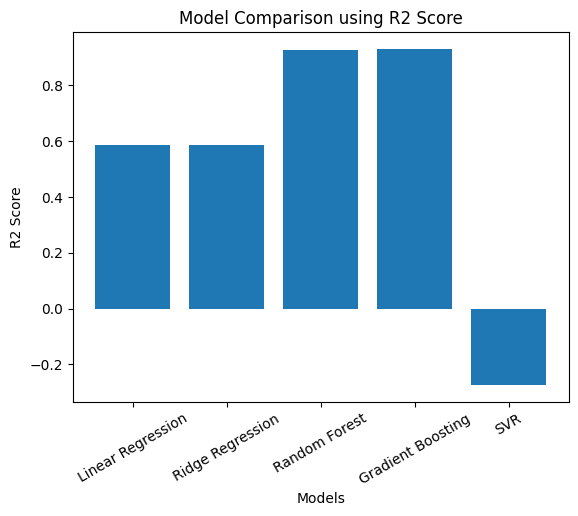

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xlabel("Models")
plt.ylabel("R2 Score")
plt.title("Model Comparison using R2 Score")
plt.xticks(rotation=30)
plt.show()


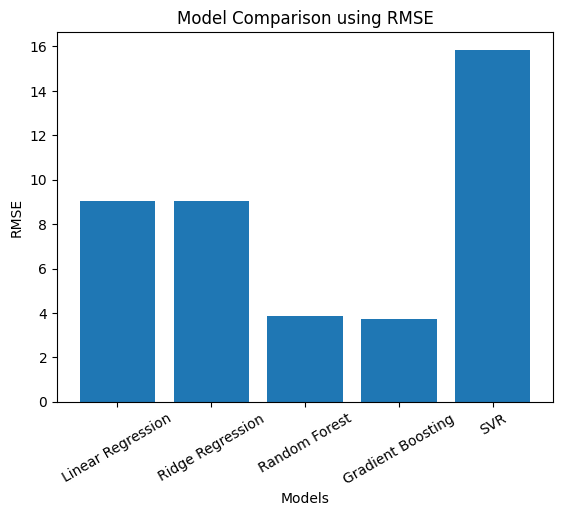

In [12]:
plt.figure()
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.title("Model Comparison using RMSE")
plt.xticks(rotation=30)
plt.show()


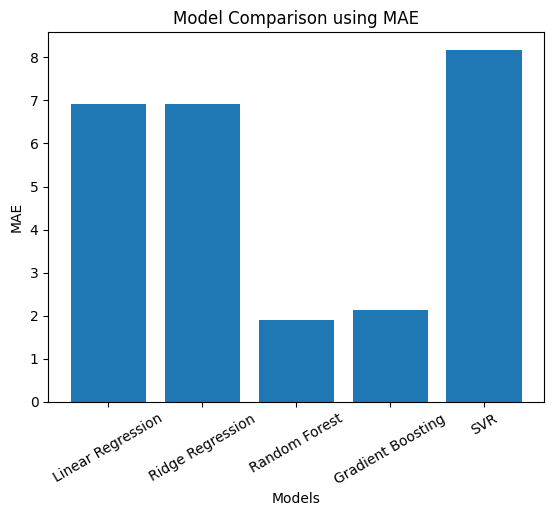

In [13]:
plt.figure()
plt.bar(results_df["Model"], results_df["MAE"])
plt.xlabel("Models")
plt.ylabel("MAE")
plt.title("Model Comparison using MAE")
plt.xticks(rotation=30)
plt.show()


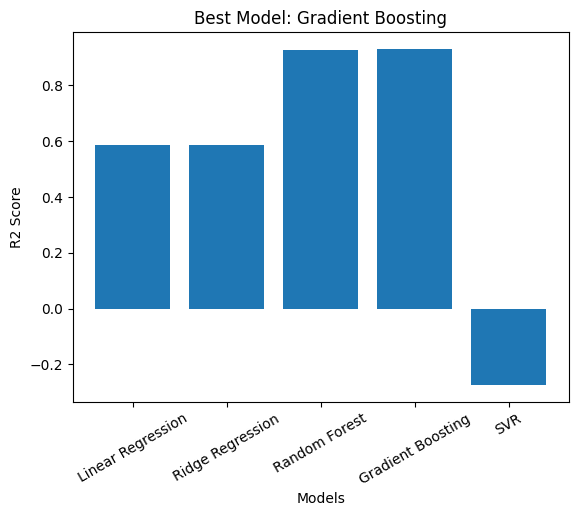

<Figure size 640x480 with 0 Axes>

In [15]:
best_model_name = best_model["Model"]

plt.figure()
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xlabel("Models")
plt.ylabel("R2 Score")
plt.title(f"Best Model: {best_model_name}")
plt.xticks(rotation=30)
plt.show()
plt.savefig("best_model_comparison.png", bbox_inches="tight")
